# Ноутбук с симуляцией ATL

## Установка и импорты

Если используется GPU, выставляем соответствующий флаг

In [2]:
GPU = False
# GPU = True

При использовании Google Colab данные удобно брать с Google диска

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Устанавливаем библиотеки, если они не установлены

In [ ]:
# !pip install pyffs
# !pip install pint
# !pip install cupy

Импорты:

In [3]:
if GPU:
    import cupy as np
else:
    import numpy as np
    
import matplotlib.pyplot as plt
import scipy.stats as sps

from PIL import Image
from pyffs import ffsn, iffsn

import pint
u = pint.UnitRegistry()
MAX_INTENS = 256

## Симуляции

### compute_carpet: Функция, считающая картину саморепродукции на определенном расстоянии

### compute_ATL: Симуляция ATL картины по маске

In [4]:
def my_matmul(a, m):
    if np.isscalar(a):
        return a * m
    else:
        return np.outer(a, m).reshape(len(a), m.shape[0], m.shape[1])
    
def compute_carpet(mask, wavelength, T_x, T_y, z):
    '''
    Функция для вычисления ковра Талбота
    param mask: изображение маски,
    param wavelength: длина волны [мм],
    param T_x: период маски по оси x [мм],
    param T_y: период маски по оси y [мм],
    param z: расстояние от картины до маски [мм]

    return: изображение картины
    '''

    mask_array = np.sqrt(np.array(mask))
    
    N = mask_array.shape[0]
    n = (N - 1) // 2

    T = np.array([T_x, T_y])
    # T = np.array([float(T_x / u.mm), float(T_y / u.mm)])
    T_c = T / 2
    N_FS = [N, N]
    
    F = ffsn((mask_array), T, T_c, N_FS)
    f_x = np.reshape(np.arange(-n, n + 1) / T[0], (1, -1))
    f_y = np.reshape(np.arange(-n, n + 1) / T[1], (-1, 1))

    # z = float(z / u.mm)
    # wavelength = np.array(wavelength / u.mm)

    H = np.exp(-1j * np.pi * z * my_matmul(wavelength, (np.power(f_x, 2) + np.power(f_y, 2))))
    result_array = (iffsn((F * H), T, T_c, N_FS, axes=[1, 2]))
    return np.square(np.absolute(result_array))

def compute_atl(mask, T_x = 0.001, T_y = 0.001, wl = 1.35e-5, rel_delta_wl = 0.04):
    '''
    Функция для вычисления дифракционной картины ATL
    param mask: изображение маски,
    param T_x: период маски по оси x [мм],
    param T_y: период маски по оси y [мм],
    param wl: длина волны [мм],
    param rel_delta_wl: относительная немонохроматичность [мм]

    return: изображение картины
    '''

    grid_size = 500
    c = 299792458e3 # speed of light in mm/s
    freq = c / wl
    delta_freq = freq * rel_delta_wl
    freq_grid = np.linspace(freq - delta_freq, freq + delta_freq, grid_size)

    grid = np.linspace(-2, 2, grid_size)
    if GPU:
        intens = sps.norm.pdf(grid.get())
    else:
        intens = sps.norm.pdf(grid)
    
    z_A = 2 * max(T_x, T_y) ** 2 / (rel_delta_wl * wl)
    carp = compute_carpet(mask, (c / freq_grid), T_x, T_y, 2 * z_A)
    return np.average(carp, axis=0, weights=intens).astype(np.float16)

def reduce_period(pic):
    period = 1
    wavelength = np.array([0.1])
    z = 10
    return (np.clip(compute_carpet(pic, wavelength, period, period, z)[0] + pic, 0, 255)).astype(np.uint8)
    # res[res > 255] = 255
    # return res.astype(np.uint8)

### Удобные функции для визуализации результата

In [12]:
def periodic_image(arr, reps):
    pic = np.tile(arr, (reps, reps))
    return Image.fromarray(pic)

def frame_plot(arr, ax):
    rectX = np.linspace(0, 1, arr.shape[0])
    rectY = np.linspace(0, 1, arr.shape[1])
    x, y = np.meshgrid(rectX, rectY)
    if GPU:
        ax.pcolormesh(x.get(), y.get(), arr.get())
    else:
        ax.pcolormesh(x, y, arr)

def check_dataset(im_num):
  sims = np.load('/content/drive/MyDrive/simulations.npy')
  masks = np.load('/content/drive/MyDrive/dataset.npy')
  fig, ax = plt.subplots(2, im_num, figsize=(im_num * 4, 8))
  fig.tight_layout()
  index = np.random.randint(0, sims.shape[0], size=im_num)
  for i in range(im_num):
    frame_plot(sims[index[i]], ax[1, i])
    frame_plot(masks[index[i]], ax[0, i])
  fig.show()

## Тесты и вычисления

В этой ячейке можно уменьшить период картинки в $\sqrt{2}$ раз, добавив элементы по углам. Это полезно сделать перед предсказанием, поскольку почти все симуляции ATL обладают уменьшенным периодом.

In [8]:
filename = 'ellipse'
pic = np.array(Image.open(f'image/{filename}.png').convert("L"))
mean = np.max(pic) / 2 + np.min(pic) / 2
pic = np.where(reduce_period(np.where(pic > mean, 255, 0)) > mean, 255, 0)
im = Image.fromarray(pic).convert('L')
im.save(f'image/{filename}.png')
im.show()

Вычислим ATL картину от маски. Задаем параметры и переводим в миллиметры

In [9]:
wl = 13.5 * u.nm
rel_delta_wl = 0.04
p = 1 * u.um

wl = float(wl / u.mm)
# delta_wl = float(delta_wl / u.mm)
p = float(p / u.mm)

Загружаем маску и считаем результат

In [63]:
mask = np.array(Image.open("image/mask_rect.png").convert("L"))

result = compute_atl(mask, p, p, wl, rel_delta_wl)

Проверяем

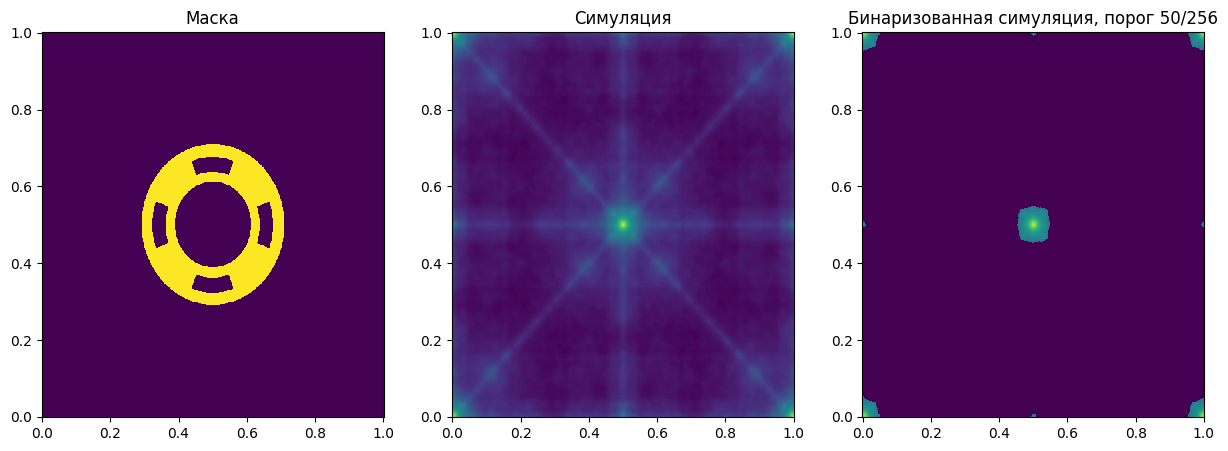

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
frame_plot(np.array(mask), ax=ax[0])
frame_plot(result, ax=ax[1])
filtered = np.where(result > 50, result, 0)
frame_plot(filtered, ax=ax[2])
ax[0].set_title('Маска');
ax[1].set_title('Симуляция');
ax[2].set_title('Бинаризованная симуляция, порог 50/256');
fig.savefig('image/predict_plot.png')

Ширина отрезанного квадрата

In [34]:
np.count_nonzero(filtered[256][100:400])

50

In [43]:
mask_rect = np.array(Image.open("image/rect40.png").convert("L"))

atl_rect = compute_atl(mask_rect)

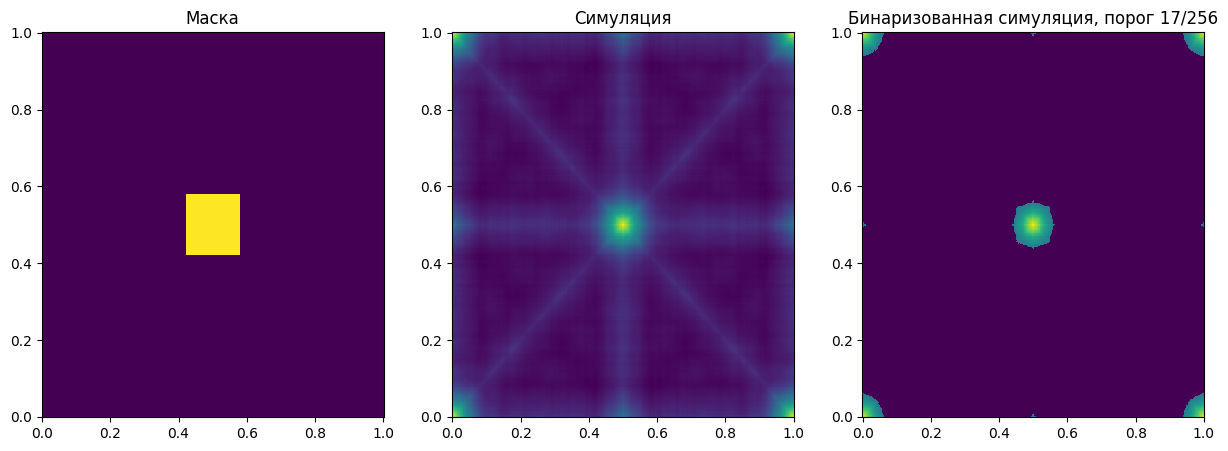

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
frame_plot(mask_rect, ax=ax[0])
frame_plot(atl_rect, ax=ax[1])
filt_rect = np.where(atl_rect > 17, atl_rect, 0)
frame_plot(filt_rect, ax=ax[2])
ax[0].set_title('Маска');
ax[1].set_title('Симуляция');
ax[2].set_title('Бинаризованная симуляция, порог 17/256');
fig.savefig('image/rect_plot.png')

In [51]:
np.count_nonzero(filt_rect[256][100:400])

65

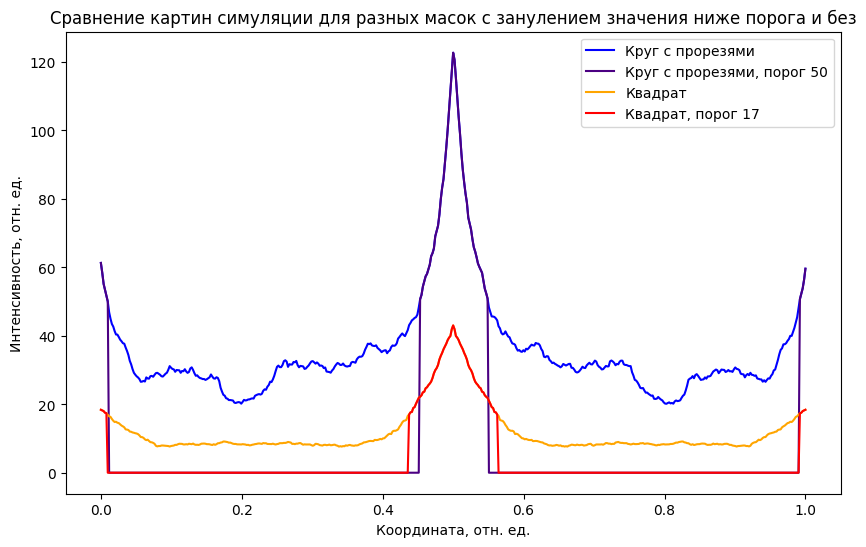

In [60]:
grid = np.linspace(0, 1, 513)
plt.figure(figsize=(10, 6))
plt.title('Сравнение картин симуляции для разных масок с занулением значения ниже порога и без')
plt.plot(grid, result[256], label='Круг с прорезями', color='blue')
plt.plot(grid, filtered[256], label='Круг с прорезями, порог 50', color='indigo')
plt.plot(grid, atl_rect[256], label='Квадрат', color='orange')
plt.plot(grid, filt_rect[256], label='Квадрат, порог 17', color='red')
plt.ylabel('Интенсивность, отн. ед.')
plt.xlabel('Координата, отн. ед.')
plt.legend();
plt.savefig('image/comparison.png')

### Датасет

Ячейки ниже использовались для того, чтобы посчитать симуляцию по всем сгенерированным случайным картинкам. Без GPU и колаба работать это будет очень долго.

In [ ]:
masks = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)
pics = []

In [ ]:
for i in range(masks.shape[0]):
  # pics.append(compute_atl(masks[i], p, p, wl, rel_delta_wl).get())
  rp = reduce_period(masks[i]).get()
  if np.sum(rp > 128) / (513 * 513) < 0.6:
    pics.append(rp)

In [ ]:
# np.save('/content/drive/MyDrive/simulations.npy', pics)
np.save('/content/drive/MyDrive/sim_pattern.npy', pics)

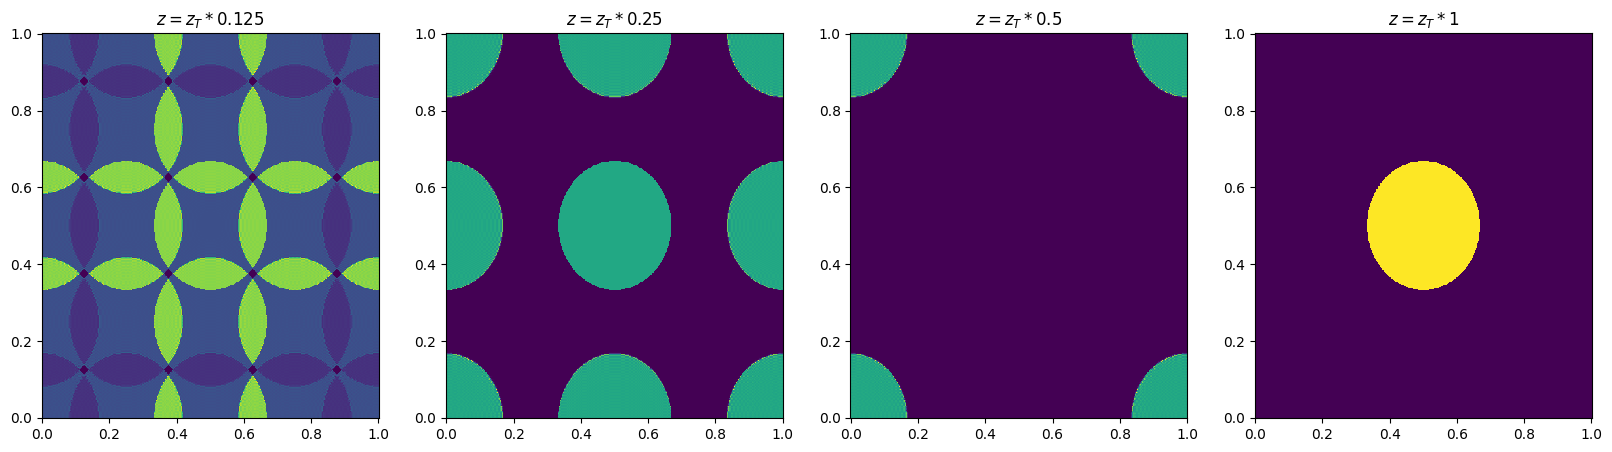

In [31]:
mask = np.array(Image.open("image/circle.png").convert("L"))
period = 1
wavelength = np.array([0.1])
z_T = 20
distances = [1/8, 1/4, 1/2, 1]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    sim = compute_carpet(mask, wavelength, period, period, z_T * distances[i])[0]
    frame_plot(sim, ax[i])
    ax[i].set_title(f'$z = z_T * {distances[i]}$')

fig.savefig('image/talbot.png')

In [ ]:
atl = compute_atl(mask)

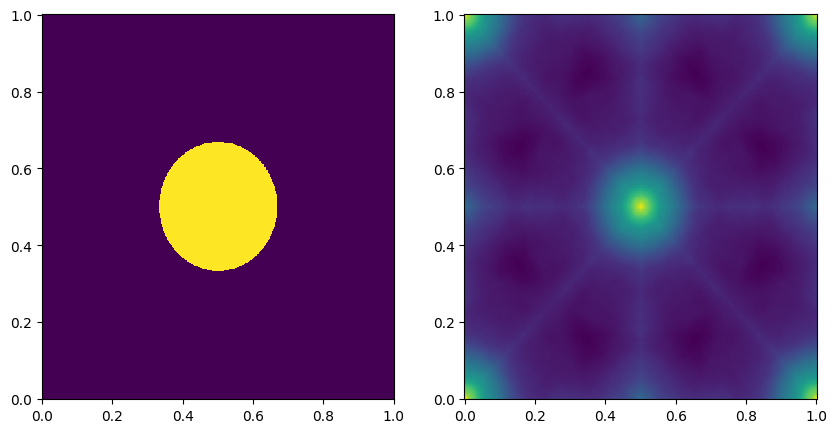

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
frame_plot(mask, ax[0])
frame_plot(atl, ax[1])
fig.savefig('image/atl.png')